# ipywidgets interact sample

ref: https://github.com/tirthajyoti/Interactive_Machine_Learning/blob/master/Interactive%20ML-Regression.ipynb

Tips: If you cannot use _interact_ func, try do this:

jupyter notebook:

```sh
jupyter nbextension enable --py widgetsnbextension
```

jupyter lab:

```sh
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import ipywidgets as widgets

from ipywidgets import (fixed, interact, interactive, IntSlider, Layout, interact_manual)
from IPython.display import (clear_output, display)

sns.set(style='white', font='Osaka', context='notebook', palette='deep')

import logging
import pprint
import sys
import warnings

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.setLevel(logging.INFO)

%matplotlib inline
# %matplotlib notebook

#### Variables

In [2]:
x_min = -5
x_max = 5
N = 50
# Assume noise follows normal distribution with the mean is zero.
# noise_mean = 0
noise_std = .5

#### function for interact

In [3]:
# HACK(fhiyo): numpy arrayが一緒に出力されてしまう．
#              clear_output()すると図も消える
@interact
def generateGeneratingFuncAndSample(N: {'20': 20, '100': 100, '500': 500}, x_min: (-5,0,1), x_max: (0,5,1), noise_std: (0,2,.25)):
    """Gerarate and Plot sin curve and sample."""
    noise_mean = 0
    x_line = np.linspace(x_min, x_max, N*5)
    y_line = np.sin(x_line)
    x = np.random.choice(x_line, size=N)
    y = np.sin(x) + np.random.normal(loc=noise_mean, scale=noise_std, size=N)

    plt.scatter(x, y, edgecolors='k', c='yellow', s=60)
    plt.plot(x_line, y_line)
    
    return x_line, y_line, x, y

interactive(children=(Dropdown(description='N', options={'20': 20, '100': 100, '500': 500}, value=20), IntSlider(value=-3, description='x_min', max=0, min=-5), IntSlider(value=2, description='x_max', max=5), FloatSlider(value=1.0, description='noise_std', max=2.0, step=0.25), Output()), _dom_classes=('widget-interact',))

#### 回帰する (interactで動的に指定したパラメータは以降の計算に反映されないので注意!)

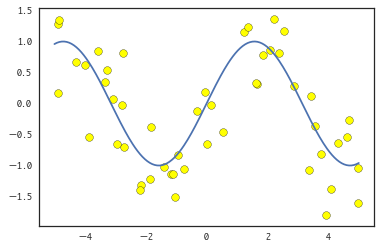

In [4]:
x_line, y_line, x, y = generateGeneratingFuncAndSample(N, x_min, x_max, noise_std)

In [5]:
# x

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [7]:
RAND_SEED = 42
LASSO_EPS = .01
LASSO_NALPHA = 20
LASSO_ITER = 3000
N_CV = 5
RIDGE_ALPHAS = [.001, .01, .1, 1]

In [8]:
# HACK(fhiyo): 名前がscikit-learnのfit()を彷彿とするのであまり良くなさそう
# 説明変数が多次元じゃないのでLassoもRidgeも大して変わらない気がするが
def fit(model_type, x, y, test_size, degree):
    """Fitting function (model is branched by model_type)."""
    def RMSE(pred, targ):
        """Calculate root mean squared error."""
        assert pred.size == targ.size
        return np.sqrt(np.mean(np.square(pred-targ)))

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=RAND_SEED)
    
    if model_type == 'Linear regression':
        model = make_pipeline(PolynomialFeatures(degree,
                                                 interaction_only=False),
                              LinearRegression(normalize=True))
    elif model_type == 'Lasso CV':
        model = make_pipeline(PolynomialFeatures(degree,
                                                 interaction_only=False),
                              LassoCV(eps=LASSO_EPS,
                                      n_alphas=LASSO_NALPHA,
                                      max_iter=LASSO_ITER,
                                      normalize=True,
                                      cv=N_CV))
    elif model_type == 'Ridge CV':
        model = make_pipeline(PolynomialFeatures(degree,
                                                 interaction_only=False),
                              RidgeCV(alphas=RIDGE_ALPHAS,
                                      normalize=True,
                                      cv=N_CV))
    else:
        raise Exception('Invalid model type.')
        
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    train_score = model.score(X_train, y_train)
    test_pred = model.predict(X_test)
    test_score = model.score(X_test, y_test)
    
    RMSE_train = RMSE(train_pred, y_train)
    RMSE_test = RMSE(test_pred, y_test)
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.title('Test set preformance\nTest score: {: .3f}'.format(test_score),
              fontsize=16)
    plt.xlabel('X-test', fontsize=13)
    plt.ylabel('y-test', fontsize=13)
    plt.scatter(X_test, y_test, edgecolors='k', c='blue', s=60)
    plt.scatter(X_test, test_pred, edgecolors='k', c='yellow', s=60)
    plt.grid(True)
    plt.legend(['Actual test values', 'Predicted test values'])
    
    plt.subplot(1, 2, 2)
    plt.title('Train set preformance\nTraining score: {: .3f}'.format(train_score),
              fontsize=16)
    plt.xlabel('X-train', fontsize=13)
    plt.ylabel('y-train', fontsize=13)
    plt.scatter(X_train, y_train, edgecolors='k', c='blue', s=60)
    plt.scatter(X_train, train_pred, edgecolors='k', c='yellow', s=60)
    plt.grid(True)
    plt.legend(['Actual train values', 'Predicted train values'])

#### Run the ML functions with ipywidget interactive

In [9]:
STYLE = {'description_width': 'initial'}

m = interactive(fit,
                model_type=widgets.RadioButtons(options=['Linear regression',
                                                         'Lasso CV',
                                                         'Ridge CV'],
                                                style=STYLE,
                                                description='Choose Model',
                                                layout=Layout(width='250px')),
                x=fixed(x),
                y=fixed(y),
                test_size=widgets.Dropdown(options={'10% of data': .1,
                                                    '20% of data': .2,
                                                    '30% of data': .3,
                                                    '40% of data': .4,},
                                           description='test set size ($X_{test}$)',
                                           style=STYLE,
                                           layout=Layout(width='250px')),
                degree=widgets.IntSlider(min=1, max=20, step=1, description='Polynomial($\sum\limits_{i=1}^n a_nx^n$)',
                                         continuous_update=False,
                                         style=STYLE,
                                         layout=Layout(width='250px')))

display(m)

interactive(children=(RadioButtons(description='Choose Model', layout=Layout(width='250px'), options=('Linear regression', 'Lasso CV', 'Ridge CV'), style=DescriptionStyle(description_width='initial'), value='Linear regression'), Dropdown(description='test set size ($X_{test}$)', layout=Layout(width='250px'), options={'10% of data': 0.1, '20% of data': 0.2, '30% of data': 0.3, '40% of data': 0.4}, style=DescriptionStyle(description_width='initial'), value=0.1), IntSlider(value=1, continuous_update=False, description='Polynomial($\\sum\\limits_{i=1}^n a_nx^n$)', layout=Layout(width='250px'), max=20, min=1, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))